<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_LSTM_(v4_Korjattu_GitHub_lataus).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch versio: 2.6.0+cu124
TensorFlow versio: 2.18.0
--- PyTorch LSTM Multi-Step Ozone Forecasting Script (v4 - Load from GitHub Fix) ---

--- 1. Ladataan esikäsitelty data ---
Ladataan Parquet-tiedosto suoraan URL:sta: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/processed/processed_hourly_ozone_weather_data.parquet
Ladattu onnistuneesti data URL:sta.
Datan muoto: (43848, 5)
Indeksi ja taajuus tarkistettu.
Poistettu sääsarakkeet: ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Ilmanpaineen keskiarvo [hPa]', 'Tuulen suunnan keskiarvo [°]']

--- 2. Piirteiden muokkaus ---
Luodaan aikaan perustuvia piirteitä...
Luodaan otsonin viivepiirteet [1, 2, 3, 6, 12, 24, 48, 72] tunnin jaksoilla...
Luodaan otsonin liukuvia tilastoja [3, 6, 12, 24] tunnin ikkunoilla...
Poistettu 72 riviä piirteiden muokkauksen jälkeen.

Käytetään 25 piirrettä LSTM-syötteenä.

--- 3. Skaalataan piirteet välille [0, 1] ---
Kohdemuuttujan skaalain sovitettu.
Koko data ska

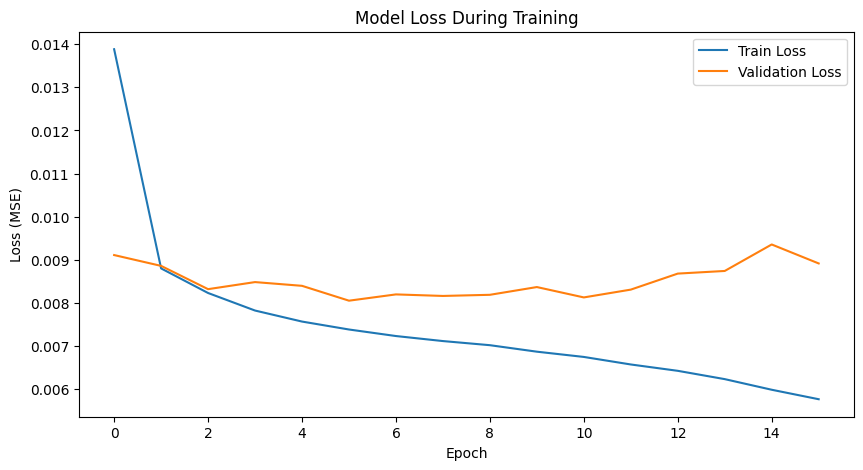


--- 9. Ennusteiden tekeminen testisekvensseille ---
Skaalattujen ennusteiden muoto: (6553, 24)

--- 10. Skaalataan ennusteet ja todelliset arvot takaisin ---
Ennusteiden ja todellisten arvojen DataFramet luotu.

--- 11. Mallin evaluointi (Regressio - RMSE/MAE per askel) ---
RMSE / MAE kullekin ennusteaskeleelle:
  +1h: RMSE=6.193, MAE=4.566 (6553 paria)
  +2h: RMSE=8.398, MAE=6.201 (6553 paria)
  +3h: RMSE=9.999, MAE=7.452 (6553 paria)
  +4h: RMSE=11.209, MAE=8.466 (6553 paria)
  +5h: RMSE=12.204, MAE=9.293 (6553 paria)
  +6h: RMSE=12.942, MAE=9.914 (6553 paria)
  +7h: RMSE=13.559, MAE=10.441 (6553 paria)
  +8h: RMSE=14.078, MAE=10.893 (6553 paria)
  +9h: RMSE=14.555, MAE=11.305 (6553 paria)
  +10h: RMSE=14.933, MAE=11.644 (6553 paria)
  +11h: RMSE=15.196, MAE=11.864 (6553 paria)
  +12h: RMSE=15.408, MAE=12.045 (6553 paria)
  +13h: RMSE=15.632, MAE=12.230 (6553 paria)
  +14h: RMSE=15.759, MAE=12.333 (6553 paria)
  +15h: RMSE=15.829, MAE=12.408 (6553 paria)
  +16h: RMSE=15.869, MAE=12.

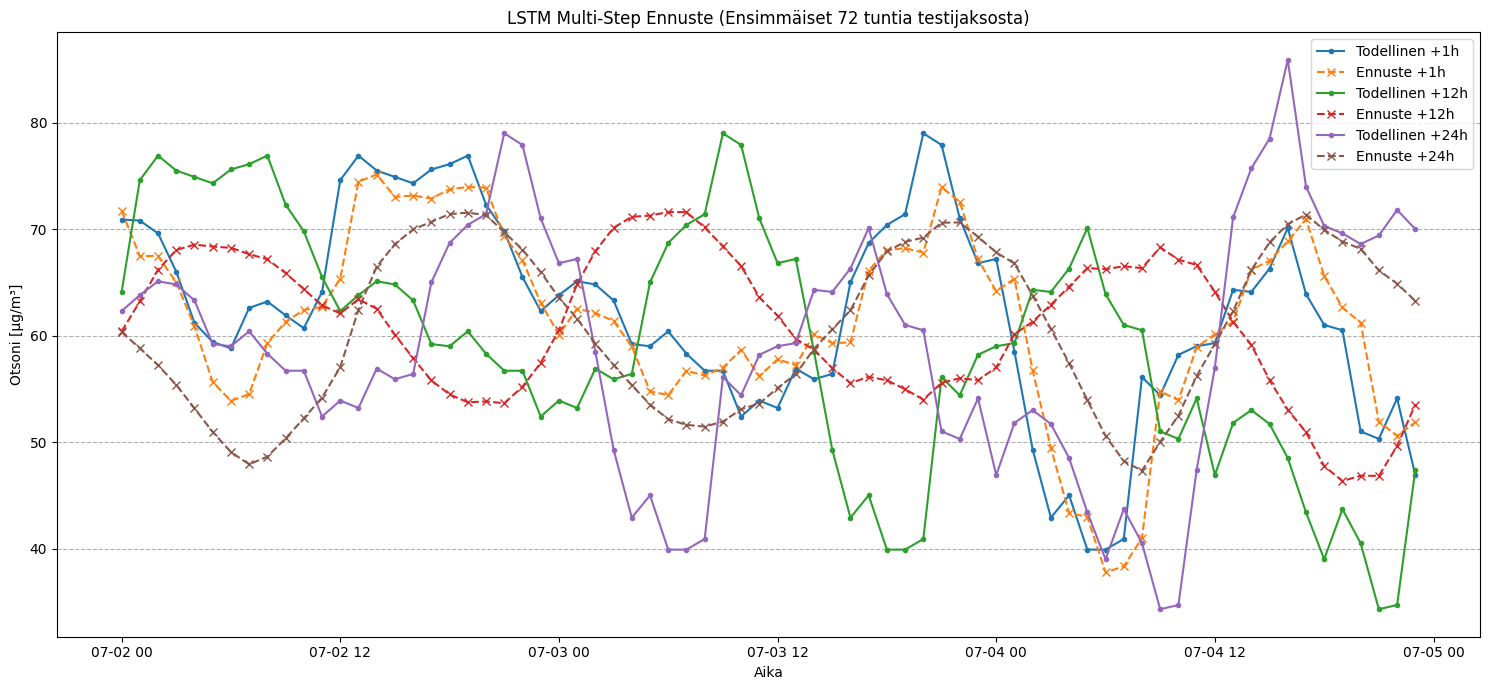

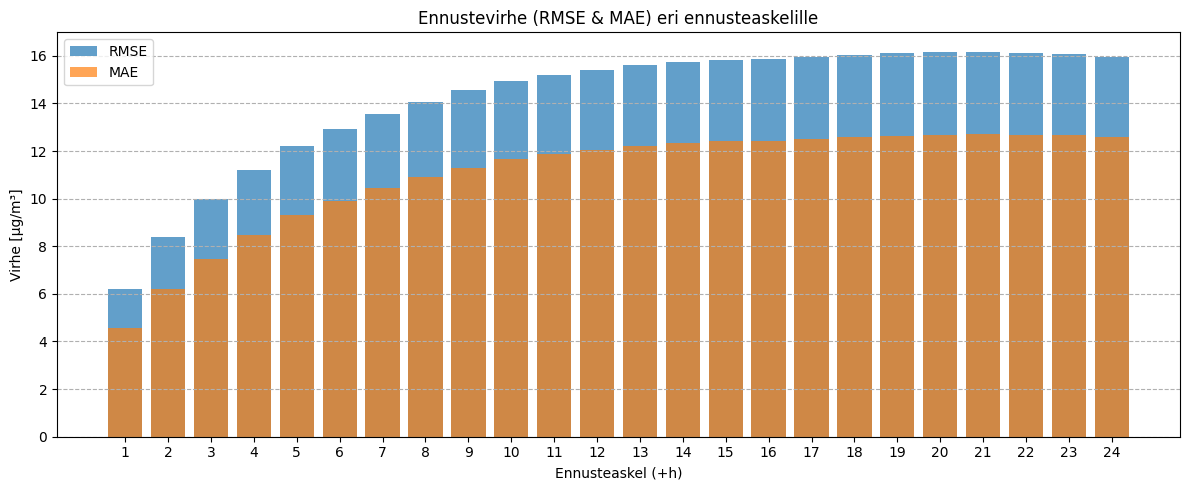


--- 14. Mallien vertailu (Päivitetty LSTM:llä) ---
                Accuracy  Precision (Spike)  Recall (Spike)  F1-score (Spike)  \
LSTM (Stacked)    0.9631              0.837          0.5842            0.6881   

               ROC AUC PR AUC  
LSTM (Stacked)     N/A    N/A  

--- LSTM-skripti päättyi ---


<ipython-input-1-10b9b3914cfd>:322: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  comparison_df.fillna("N/A", inplace=True)


In [1]:
# -*- coding: utf-8 -*-
"""
Colab Script for Multi-Step Ozone Forecasting using LSTM with PyTorch - v4

Loads the preprocessed data DIRECTLY FROM GITHUB, engineers features,
scales data, creates sequences, builds/trains LSTM, predicts,
evaluates (incl. classification metrics for +1h spike),
and creates improved visualizations. Corrected GitHub loading.
"""

# Kirjastojen tuonti
import pandas as pd
import numpy as np
import io
import requests # Vaikka pandas hoitaa latauksen, hyvä olla mukana
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import re
import time

# Koneoppimiskirjastot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc)
from math import sqrt

# PyTorch Kirjastot
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader
    print(f"PyTorch versio: {torch.__version__}")
except ImportError:
    print("VIRHE: PyTorch kirjastoa ei löytynyt. Asenna se: !pip install torch")

# TensorFlow/Keras (vain varmuuden vuoksi)
try:
    import tensorflow as tf
    # from tensorflow import keras # Ei tarvita enää EarlyStoppingia tässä
    print(f"TensorFlow versio: {tf.__version__}")
except ImportError:
    print("Varoitus: TensorFlow/Keras kirjastoa ei löytynyt.")


print("--- PyTorch LSTM Multi-Step Ozone Forecasting Script (v4 - Load from GitHub Fix) ---")

# --- Globaali sanakirja mallien vertailuun ---
try:
    if 'model_comparison_metrics' not in globals(): model_comparison_metrics = {}
except NameError: model_comparison_metrics = {}

# --- 1. Ladataan esikäsitelty data GitHubista ---
print("\n--- 1. Ladataan esikäsitelty data ---")
# *** KORJATTU: Käytetään suoraa raw-linkkiä GitHubiin ***
processed_data_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/processed/processed_hourly_ozone_weather_data.parquet"
df_processed = None
try:
    print(f"Ladataan Parquet-tiedosto suoraan URL:sta: {processed_data_url}")
    # Käytä URL:ää tiedostonimen sijaan pd.read_parquet-kutsussa
    # Varmista että pyarrow tai fastparquet on asennettu
    df_processed = pd.read_parquet(processed_data_url)
    print(f"Ladattu onnistuneesti data URL:sta.")
    print(f"Datan muoto: {df_processed.shape}")
    # Varmista, että indeksi on DatetimeIndex
    if not isinstance(df_processed.index, pd.DatetimeIndex):
        print("Muunnetaan indeksi DatetimeIndexiksi...")
        df_processed.index = pd.to_datetime(df_processed.index)
    # Varmista, että taajuus on asetettu (resample teki tämän)
    df_processed = df_processed.asfreq('h')
    print("Indeksi ja taajuus tarkistettu.")
    # print(df_processed.info()) # Vähemmän tulostetta

# Poistettu FileNotFoundError, koska virhe olisi nyt todennäköisemmin esim. HTTPError tai lukuongelma
except ImportError:
    print("\nVirhe: Parquet-tiedoston lukeminen URL:sta vaatii 'pyarrow' tai 'fastparquet'.")
    print("Asenna se Colabissa komennolla: !pip install pyarrow")
    df_processed = None # Estä jatko
except Exception as e:
    # Virhe voi olla esim. 404 Not Found jos URL on väärin, tai lukuvirhe
    print(f"Virhe esikäsitellyn datan latauksessa URL:sta: {e}")
    traceback.print_exc()
    df_processed = None # Estä jatko


# Jatka vain jos data ladattiin onnistuneesti
if df_processed is not None and not df_processed.empty:

    o3_col = "Otsoni [µg/m³]"
    # Poistetaan sääsarakkeet, koska emme käytä niitä tässä mallissa
    weather_cols_to_drop = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Ilmanpaineen keskiarvo [hPa]', 'Tuulen suunnan keskiarvo [°]']
    cols_present_to_drop = [col for col in weather_cols_to_drop if col in df_processed.columns]
    if cols_present_to_drop:
        df_processed = df_processed.drop(columns=cols_present_to_drop)
        print(f"Poistettu sääsarakkeet: {cols_present_to_drop}")

    # --- 2. Piirteiden muokkaus (Otsoni + Aika) ---
    print("\n--- 2. Piirteiden muokkaus ---")
    # (Sama kuin v3)
    print("Luodaan aikaan perustuvia piirteitä...")
    df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed.index.hour / 24); df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed.index.hour / 24)
    df_processed['dayofweek_sin'] = np.sin(2 * np.pi * df_processed.index.dayofweek / 7); df_processed['dayofweek_cos'] = np.cos(2 * np.pi * df_processed.index.dayofweek / 7)
    df_processed['month_sin'] = np.sin(2 * np.pi * df_processed.index.month / 12); df_processed['month_cos'] = np.cos(2 * np.pi * df_processed.index.month / 12)
    df_processed['dayofyear_sin'] = np.sin(2 * np.pi * df_processed.index.dayofyear / 365.2425); df_processed['dayofyear_cos'] = np.cos(2 * np.pi * df_processed.index.dayofyear / 365.2425)
    lag_periods = [1, 2, 3, 6, 12, 24, 48, 72]
    print(f"Luodaan otsonin viivepiirteet {lag_periods} tunnin jaksoilla...")
    for lag in lag_periods: df_processed[f'Otsoni_lag{lag}'] = df_processed[o3_col].shift(lag)
    rolling_window_hours = [3, 6, 12, 24]
    print(f"Luodaan otsonin liukuvia tilastoja {rolling_window_hours} tunnin ikkunoilla...")
    shifted_o3 = df_processed[o3_col].shift(1)
    for window in rolling_window_hours:
        df_processed[f'Otsoni_roll_mean_{window}h'] = shifted_o3.rolling(window=window).mean()
        df_processed[f'Otsoni_roll_std_{window}h'] = shifted_o3.rolling(window=window).std()
    initial_rows = len(df_processed); df_processed.dropna(inplace=True)
    print(f"Poistettu {initial_rows - len(df_processed)} riviä piirteiden muokkauksen jälkeen.")
    features_for_lstm = df_processed.columns.tolist()
    print(f"\nKäytetään {len(features_for_lstm)} piirrettä LSTM-syötteenä.")
    if df_processed.empty: print("Virhe: Data tyhjä piirteiden muokkauksen jälkeen."); df_processed = None

if df_processed is not None:
    # --- 3. Datan Skaalaus ---
    print("\n--- 3. Skaalataan piirteet välille [0, 1] ---")
    scaler_target = MinMaxScaler(feature_range=(0, 1)); scaler_target.fit(df_processed[[o3_col]])
    print("Kohdemuuttujan skaalain sovitettu.")
    scaler = MinMaxScaler(feature_range=(0, 1)); scaled_data = scaler.fit_transform(df_processed)
    df_scaled = pd.DataFrame(scaled_data, index=df_processed.index, columns=features_for_lstm)
    print("Koko data skaalattu."); print(f"Skaalatun datan muoto: {df_scaled.shape}")

    # --- 4. Sekvenssien luonti ---
    print("\n--- 4. Luodaan syöte- ja kohdesekvenssit LSTM-mallille ---")
    n_steps_in = 72; n_steps_out = 24
    print(f"Käytetään {n_steps_in}h historiaa ennustamaan seuraavat {n_steps_out}h.")
    def create_sequences_pytorch(input_data, target_data, n_steps_in, n_steps_out):
        X, y = [], []; print(f"Luodaan sekvenssejä datasta, jossa rivejä: {len(input_data)}")
        for i in range(len(input_data) - n_steps_in - n_steps_out + 1):
            seq_in = input_data[i : i + n_steps_in]; seq_out = target_data[i + n_steps_in : i + n_steps_in + n_steps_out]
            X.append(seq_in); y.append(seq_out)
        print(f"Sekvenssien luonti valmis. Näytteitä: {len(X)}")
        # Varmista numpy array ennen tensoriksi muuntoa
        return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)
    try: target_col_idx_scaled = df_scaled.columns.get_loc(o3_col)
    except KeyError: print(f"Virhe: Kohdesaraketta '{o3_col}' ei löytynyt."); df_processed = None
    if df_processed is not None:
        X_seq_tensor, y_seq_tensor = create_sequences_pytorch(df_scaled.values, df_scaled.iloc[:, target_col_idx_scaled].values, n_steps_in, n_steps_out)
        if X_seq_tensor.shape[0] == 0: print("Virhe: Sekvenssejä ei voitu luoda."); df_processed = None

if df_processed is not None:
    # --- 5. Datan jako opetus- ja testisekvensseihin ---
    print("\n--- 5. Datan jako opetus- ja testisekvensseihin ---")
    test_split_ratio = 0.15; split_idx_seq = int(X_seq_tensor.shape[0] * (1 - test_split_ratio))
    X_train_seq, X_test_seq = X_seq_tensor[:split_idx_seq], X_seq_tensor[split_idx_seq:]
    y_train_seq, y_test_seq = y_seq_tensor[:split_idx_seq], y_seq_tensor[split_idx_seq:]
    df_lstm_input = df_processed[features_for_lstm] # Tarvitaan indeksiä varten
    test_start_iloc = split_idx_seq + n_steps_in; test_end_iloc = test_start_iloc + len(y_test_seq)
    # Varmista, että indeksit ovat olemassa ennen viipalointia
    if test_start_iloc < len(df_lstm_input.index) and test_end_iloc <= len(df_lstm_input.index):
         test_indices = df_lstm_input.index[test_start_iloc:test_end_iloc]
    else:
         print("Varoitus: Ei voitu määrittää tarkkoja testi-indeksejä. Käytetään oletusindeksiä.")
         test_indices = pd.RangeIndex(start=0, stop=len(y_test_seq)) # Oletusindeksi

    print(f"Opetussekvenssit: X={X_train_seq.shape}, y={y_train_seq.shape}")
    print(f"Testisekvenssit: X={X_test_seq.shape}, y={y_test_seq.shape}")
    if isinstance(test_indices, pd.DatetimeIndex):
         print(f"Testijakson indeksit: {len(test_indices)} kpl, alkaen {test_indices.min()}, päättyen {test_indices.max()}")
    else:
         print(f"Testijakson indeksit: {len(test_indices)} kpl (oletusindeksi)")


    # --- 6. PyTorch DataLoaderit ---
    print("\n--- 6. Luodaan PyTorch DataLoaderit ---")
    batch_size = 64; train_dataset = TensorDataset(X_train_seq, y_train_seq); train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test_seq, y_test_seq); test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(f"DataLoaderit luotu batch koolla {batch_size}.")

    # --- 7. LSTM-mallin määrittely (PyTorch - Stacked + Dropout) ---
    print("\n--- 7. LSTM-mallin määrittely (PyTorch - Stacked + Dropout) ---")
    n_features = X_train_seq.shape[2]; n_hidden1 = 100; n_hidden2 = 50; dropout_prob = 0.2
    class StackedLSTMModel(nn.Module):
        def __init__(self, n_features, n_hidden1, n_hidden2, n_steps_out, dropout_prob):
            super().__init__(); self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=n_hidden1, batch_first=True)
            self.dropout1 = nn.Dropout(dropout_prob); self.lstm2 = nn.LSTM(input_size=n_hidden1, hidden_size=n_hidden2, batch_first=True)
            self.dropout2 = nn.Dropout(dropout_prob); self.linear = nn.Linear(in_features=n_hidden2, out_features=n_steps_out)
        def forward(self, x):
            lstm_out1, _ = self.lstm1(x); lstm_out1 = self.dropout1(lstm_out1)
            lstm_out2, (hidden, cell) = self.lstm2(lstm_out1); lstm_out2 = self.dropout2(lstm_out2)
            prediction = self.linear(lstm_out2[:, -1, :]); return prediction
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Käytetään laitetta: {device}")
    model = StackedLSTMModel(n_features, n_hidden1, n_hidden2, n_steps_out, dropout_prob).to(device)
    print("Stacked LSTM-malli alustettu.")

    # --- 8. Mallin koulutus (PyTorch) ---
    print("\n--- 8. Mallin koulutus ---")
    loss_function = nn.MSELoss(); optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50; patience = 10; best_val_loss = float('inf'); patience_counter = 0
    train_losses = []; val_losses = []
    start_train_time = time.time()
    for epoch in range(epochs):
        model.train(); epoch_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch); loss = loss_function(y_pred, y_batch)
            epoch_train_loss += loss.item()
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        avg_train_loss = epoch_train_loss / len(train_loader); train_losses.append(avg_train_loss)
        model.eval(); epoch_val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in test_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = model(X_val_batch); val_loss = loss_function(y_val_pred, y_val_batch)
                epoch_val_loss += val_loss.item()
        avg_val_loss = epoch_val_loss / len(test_loader); val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")
        if avg_val_loss < best_val_loss: best_val_loss = avg_val_loss; patience_counter = 0
        else: patience_counter += 1;
        if patience_counter >= patience: print(f"Early stopping epoch {epoch+1}."); break
    end_train_time = time.time(); print(f"Malli koulutettu. Kesto: {(end_train_time - start_train_time):.2f} sekuntia.")
    plt.figure(figsize=(10, 5)); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Validation Loss'); plt.title('Model Loss During Training'); plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)'); plt.legend(); plt.show()

    # --- 9. Ennusteiden tekeminen ---
    print("\n--- 9. Ennusteiden tekeminen testisekvensseille ---")
    model.eval(); all_predictions_scaled = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device); y_pred_batch = model(X_batch)
            all_predictions_scaled.append(y_pred_batch.cpu().numpy())
    predictions_scaled = np.concatenate(all_predictions_scaled, axis=0)
    print(f"Skaalattujen ennusteiden muoto: {predictions_scaled.shape}")

    # --- 10. Tulosten skaalaus takaisin ---
    print("\n--- 10. Skaalataan ennusteet ja todelliset arvot takaisin ---")
    df_preds, df_actuals = None, None
    try:
        predictions_rescaled_flat = scaler_target.inverse_transform(predictions_scaled.flatten().reshape(-1, 1))
        predictions_rescaled = predictions_rescaled_flat.reshape(predictions_scaled.shape)
        y_test_numpy = y_test_seq.cpu().numpy()
        y_test_rescaled_flat = scaler_target.inverse_transform(y_test_numpy.flatten().reshape(-1, 1))
        y_test_rescaled = y_test_rescaled_flat.reshape(y_test_numpy.shape)
        if len(test_indices) == len(predictions_rescaled):
            pred_cols = [f'Pred +{i+1}h' for i in range(n_steps_out)]; actual_cols = [f'Actual +{i+1}h' for i in range(n_steps_out)]
            df_preds = pd.DataFrame(predictions_rescaled, index=test_indices, columns=pred_cols)
            df_actuals = pd.DataFrame(y_test_rescaled, index=test_indices, columns=actual_cols)
            print("Ennusteiden ja todellisten arvojen DataFramet luotu.")
        else: print("Virhe: Testi-indeksien pituus ei täsmää ennusteiden pituuteen.")
    except Exception as e_inv: print(f"Virhe käänteisskaalauksessa: {e_inv}")

    # --- 11. Evaluointi (Regressio) ---
    if df_preds is not None and df_actuals is not None:
        print("\n--- 11. Mallin evaluointi (Regressio - RMSE/MAE per askel) ---")
        rmses = []; maes = []; print("RMSE / MAE kullekin ennusteaskeleelle:")
        for i in range(n_steps_out):
            if i < df_actuals.shape[1] and i < df_preds.shape[1]:
                 step_actual = df_actuals.iloc[:, i]; step_pred = df_preds.iloc[:, i]
                 valid_comp = pd.DataFrame({'act': step_actual, 'pred': step_pred}).dropna()
                 if not valid_comp.empty:
                      rmse = sqrt(mean_squared_error(valid_comp['act'], valid_comp['pred'])); mae = mean_absolute_error(valid_comp['act'], valid_comp['pred'])
                      rmses.append(rmse); maes.append(mae); print(f"  +{i+1}h: RMSE={rmse:.3f}, MAE={mae:.3f} ({len(valid_comp)} paria)")
                 else: rmses.append(np.nan); maes.append(np.nan)
            else: rmses.append(np.nan); maes.append(np.nan)
        avg_rmse = np.nanmean(rmses); avg_mae = np.nanmean(maes)
        print(f"\nKeskimääräinen RMSE ({n_steps_out}h): {avg_rmse:.3f}")
        print(f"Keskimääräinen MAE ({n_steps_out}h): {avg_mae:.3f}")

        # --- 12. Piikkien päätteleminen ja evaluointi (Luokittelu) ---
        print("\n--- 12. Piikkien päätteleminen ja evaluointi (Luokittelu) ---")
        try:
            spike_threshold_full = df_processed[o3_col].quantile(0.90); print(f"Käytetään piikin kynnysarvoa: {spike_threshold_full:.2f}")
            df_preds_binary = (df_preds > spike_threshold_full).astype(int); df_actuals_binary = (df_actuals > spike_threshold_full).astype(int)
            print("\nLuokitteluraportti ja metriikat (keskitetty +1h ennusteeseen vertailua varten):")
            step_to_eval = 0; print(f"Evaluoidaan +{step_to_eval+1}h piikkiennuste:")
            if step_to_eval < df_actuals_binary.shape[1] and step_to_eval < df_preds_binary.shape[1]:
                 actual_spikes_step = df_actuals_binary.iloc[:, step_to_eval]; predicted_spikes_step = df_preds_binary.iloc[:, step_to_eval]
                 accuracy_lstm = accuracy_score(actual_spikes_step, predicted_spikes_step); precision_spike_lstm = precision_score(actual_spikes_step, predicted_spikes_step, pos_label=1, zero_division=0); recall_spike_lstm = recall_score(actual_spikes_step, predicted_spikes_step, pos_label=1, zero_division=0); f1_spike_lstm = f1_score(actual_spikes_step, predicted_spikes_step, pos_label=1, zero_division=0); roc_auc_lstm = np.nan; pr_auc_lstm = np.nan
                 if len(np.unique(actual_spikes_step)) > 1:
                      if len(np.unique(predicted_spikes_step)) <= 1: print("Ei voitu laskea luokitteluraporttia: Malli ennusti vain yhtä luokkaa.")
                      print(classification_report(actual_spikes_step, predicted_spikes_step, zero_division=0))
                      print("Confusion Matrix (+1h):"); print(confusion_matrix(actual_spikes_step, predicted_spikes_step))
                 else: print("Ei voitu laskea luokitteluraporttia (testijaksolla ei ollut molempia luokkia).")
                 print(f"Todellisia piikkejä (+{step_to_eval+1}h): {actual_spikes_step.sum()}")
                 print(f"Ennustettuja piikkejä (+{step_to_eval+1}h): {predicted_spikes_step.sum()}")
                 model_comparison_metrics['LSTM (Stacked)'] = {
                     'Accuracy': accuracy_lstm, 'Precision (Spike)': precision_spike_lstm,
                     'Recall (Spike)': recall_spike_lstm, 'F1-score (Spike)': f1_spike_lstm,
                     'ROC AUC': roc_auc_lstm, 'PR AUC': pr_auc_lstm }
                 print("\nLSTM (+1h) metriikat tallennettu vertailuun.")
            else: print(f"Dataa ei saatavilla askeleelle +{step_to_eval+1}h luokitteluevaluointiin.")
        except Exception as e_spike: print(f"Virhe piikkien evaluoinnissa: {e_spike}")

        # --- 13. Visualisointi (Esimerkki) ---
        print("\n--- 13. Visualisoidaan esimerkki ennusteista ja virheet ajan funktiona ---")
        try:
            plot_len = min(72, len(df_actuals))
            plt.figure(figsize=(15, 7))
            plt.plot(df_actuals.index[:plot_len], df_actuals.iloc[:plot_len, 0], label='Todellinen +1h', marker='.', linestyle='-')
            plt.plot(df_preds.index[:plot_len], df_preds.iloc[:plot_len, 0], label='Ennuste +1h', marker='x', linestyle='--')
            if n_steps_out >= 12 and 11 < df_actuals.shape[1]:
                 plt.plot(df_actuals.index[:plot_len], df_actuals.iloc[:plot_len, 11], label='Todellinen +12h', marker='.', linestyle='-')
                 plt.plot(df_preds.index[:plot_len], df_preds.iloc[:plot_len, 11], label='Ennuste +12h', marker='x', linestyle='--')
            if n_steps_out >= 24 and 23 < df_actuals.shape[1]:
                 plt.plot(df_actuals.index[:plot_len], df_actuals.iloc[:plot_len, 23], label='Todellinen +24h', marker='.', linestyle='-')
                 plt.plot(df_preds.index[:plot_len], df_preds.iloc[:plot_len, 23], label='Ennuste +24h', marker='x', linestyle='--')
            plt.title(f'LSTM Multi-Step Ennuste (Ensimmäiset {plot_len} tuntia testijaksosta)')
            plt.xlabel('Aika'); plt.ylabel(o3_col); plt.legend(); plt.grid(axis='y', linestyle='--'); plt.tight_layout(); plt.show()

            plt.figure(figsize=(12, 5))
            plt.bar(range(1, n_steps_out + 1), rmses, alpha=0.7, label='RMSE')
            plt.bar(range(1, n_steps_out + 1), maes, alpha=0.7, label='MAE')
            plt.xlabel('Ennusteaskel (+h)'); plt.ylabel('Virhe [µg/m³]'); plt.title('Ennustevirhe (RMSE & MAE) eri ennusteaskelille')
            plt.xticks(range(1, n_steps_out + 1)); plt.legend(); plt.grid(axis='y', linestyle='--'); plt.tight_layout(); plt.show()
        except Exception as e_vis: print(f"Virhe visualisoinnissa: {e_vis}")

    # --- 14. Lopullinen mallien vertailu ---
    print("\n--- 14. Mallien vertailu (Päivitetty LSTM:llä) ---")
    if model_comparison_metrics:
        comparison_df = pd.DataFrame.from_dict(model_comparison_metrics, orient='index')
        comparison_df = comparison_df.round(4)
        # Täytä NaN selkeyden vuoksi
        comparison_df.fillna("N/A", inplace=True)
        # Järjestä F1-scoren mukaan (koska PR AUC puuttuu LSTM:ltä)
        if 'F1-score (Spike)' in comparison_df.columns:
             comparison_df.sort_values(by='F1-score (Spike)', ascending=False, inplace=True)
        print(comparison_df)
    else:
        print("Metriikoita ei tallennettu vertailua varten.")

else: # df_processed is None or empty
    print("\nEi voitu jatkaa mallinnukseen, koska datan esikäsittely epäonnistui.")

print("\n--- LSTM-skripti päättyi ---")